<a href="https://colab.research.google.com/github/Diyasingh03/CS573-Final/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.0/309.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 10.2 MB/s eta 0:0

#Load Test set in case not using drive folder

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foo
import os

# --- Configuration ---
# 1. Define the animal classes
ANIMAL_CLASSES = [
    "Cat", "Dog", "Bird", "Horse", "Sheep", "Elephant",
    "Bear", "Zebra", "Giraffe",
]
NUM_CLASSES = len(ANIMAL_CLASSES)
SAMPLES_PER_CLASS = 200  # Your requirement for train- 1000 test-200
MASTER_DATASET_NAME = "open-images-animal-subset"

# 2. Define where to export the data
DATASET_DIR = "./open-images-animals"
COCO_EXPORT_DIR = os.path.join(DATASET_DIR, "coco")
YOLO_EXPORT_DIR = os.path.join(DATASET_DIR, "yolo")

print(f"Targeting {SAMPLES_PER_CLASS} samples for each of {NUM_CLASSES} classes.")
print("This will download a large amount of data and may take a while...")

# --- 1. Download data per class and merge ---

# Delete master dataset if it already exists, to start fresh
if MASTER_DATASET_NAME in fo.list_datasets():
    print(f"Deleting existing dataset: '{MASTER_DATASET_NAME}'")
    fo.delete_dataset(MASTER_DATASET_NAME)

# Create an empty master dataset
master_dataset = fo.Dataset(MASTER_DATASET_NAME)
master_dataset.persistent = True  # Make sure it's saved

temp_dataset_names = []

try:
    for animal_class in ANIMAL_CLASSES:
        temp_name = f"temp-animal-subset-{animal_class}"
        temp_dataset_names.append(temp_name)

        if temp_name in fo.list_datasets():
            fo.delete_dataset(temp_name)

        print(f"\nDownloading dataset for: {animal_class}")

        # Download a view for the specific class from the TRAIN split
        class_view = foo.load_zoo_dataset(
            "open-images-v7",
            split="test",  # <-- Using the 'train' split
            label_types=["detections"],
            classes=[animal_class],  # Just this one class
            max_samples=SAMPLES_PER_CLASS,
            seed=42,
            shuffle=True,  # Get a random sample
            dataset_name=temp_name,
        )

        # Merge the samples into the master dataset
        # This will automatically handle duplicates based on filepath
        print(f"Merging {len(class_view)} samples for '{animal_class}' into master dataset...")
        master_dataset.merge_samples(class_view)
        print(f"Master dataset now has {len(master_dataset)} total unique samples.")

finally:
    # Clean up temporary datasets
    print("\nCleaning up temporary datasets...")
    for temp_name in temp_dataset_names:
        if temp_name in fo.list_datasets():
            fo.delete_dataset(temp_name)

print(f"\nTotal unique samples downloaded: {len(master_dataset)}")

# --- 2. Filter the dataset labels ---
# The download gets images with *at least* one target animal.
# This step filters the *labels* to *only* keep boxes for our ANIMAL_CLASSES.
print("Filtering non-animal labels from the master dataset...")
filtered_view = master_dataset.filter_labels(
    "ground_truth",  # Field name for Open Images detections
    fo.ViewField("label").is_in(ANIMAL_CLASSES)
)

# --- 3. Export the dataset ---

# --- Export in COCO format ---
# (For Mask R-CNN and DETR)
print(f"Exporting dataset in 'COCO' format to: {COCO_EXPORT_DIR}")
filtered_view.export(
    export_dir=COCO_EXPORT_DIR,
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth"
)

# --- Export in YOLOv5 format ---
# (For YOLOv8, which uses the YOLOv5 format)
print(f"Exporting dataset in 'YOLOv5' format to: {YOLO_EXPORT_DIR}")
filtered_view.export(
    export_dir=YOLO_EXPORT_DIR,
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    classes=ANIMAL_CLASSES  # Explicitly pass class list to ensure order
)

print("\n--- Download and Export Complete ---")
print(f"Dataset location: {DATASET_DIR}")
print(f"COCO annotations: {COCO_EXPORT_DIR}")
print(f"YOLO annotations: {YOLO_EXPORT_DIR}")
print(f"Total unique images: {len(master_dataset)}")
print("\nTo launch the FiftyOne App and visualize your dataset, run:")
print("import fiftyone as fo")
print(f"dataset = fo.load_dataset('{MASTER_DATASET_NAME}')")
print("session = fo.launch_app(dataset)")



/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Targeting 200 samples for each of 9 classes.
This will download a large amount of data and may take a while...



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv' to '/root/fiftyone/open-images-v7/test/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/test/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmp9oxgg30l/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv' to '/root/fiftyone/open-images-v7/test/labels/detections.csv'


INFO:fiftyone.utils.openimages:Downloading 200 images


 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 3.5 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 3.5 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 200/200 [582.2ms elapsed, 0s remaining, 346.1 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 200/200 [582.2ms elapsed, 0s remaining, 346.1 samples/s]      


Dataset 'temp-animal-subset-Cat' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Cat' created


Merging 200 samples for 'Cat' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Cat'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Cat'


Converting existing index 'filepath' to unique on dataset 'open-images-animal-subset'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'open-images-animal-subset'


Master dataset now has 200 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 200 images


 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 2.8 files/s]       


INFO:eta.core.utils: 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 2.8 files/s]       


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 200/200 [662.9ms elapsed, 0s remaining, 301.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 200/200 [662.9ms elapsed, 0s remaining, 301.7 samples/s]      


Dataset 'temp-animal-subset-Dog' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Dog' created


Merging 200 samples for 'Dog' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Dog'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Dog'


Master dataset now has 398 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 200 images


 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 2.4 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 2.4 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 200/200 [652.2ms elapsed, 0s remaining, 306.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 200/200 [652.2ms elapsed, 0s remaining, 306.7 samples/s]      


Dataset 'temp-animal-subset-Bird' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Bird' created


Merging 200 samples for 'Bird' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Bird'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Bird'


Master dataset now has 598 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 200 images


 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 2.8 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 200/200 [1.0m elapsed, 0s remaining, 2.8 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 200/200 [3.2s elapsed, 0s remaining, 69.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 200/200 [3.2s elapsed, 0s remaining, 69.5 samples/s]      


Dataset 'temp-animal-subset-Horse' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Horse' created


Merging 200 samples for 'Horse' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Horse'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Horse'


Master dataset now has 798 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


Only found 179 (<200) samples matching your requirements


Found 1 images, downloading the remaining 178


INFO:fiftyone.utils.openimages:Found 1 images, downloading the remaining 178


 100% |███████████████████| 178/178 [56.1s elapsed, 0s remaining, 3.5 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 178/178 [56.1s elapsed, 0s remaining, 3.5 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 179/179 [1.8s elapsed, 0s remaining, 102.4 samples/s]        


INFO:eta.core.utils: 100% |█████████████████| 179/179 [1.8s elapsed, 0s remaining, 102.4 samples/s]        


Dataset 'temp-animal-subset-Sheep' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Sheep' created


Merging 179 samples for 'Sheep' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Sheep'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Sheep'


Master dataset now has 976 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


Only found 137 (<200) samples matching your requirements


INFO:fiftyone.utils.openimages:Downloading 137 images


 100% |███████████████████| 137/137 [42.2s elapsed, 0s remaining, 3.5 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 137/137 [42.2s elapsed, 0s remaining, 3.5 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |█████████████████| 137/137 [1.7s elapsed, 0s remaining, 80.3 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 137/137 [1.7s elapsed, 0s remaining, 80.3 samples/s]         


Dataset 'temp-animal-subset-Elephant' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Elephant' created


Merging 137 samples for 'Elephant' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Elephant'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Elephant'


Master dataset now has 1113 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


Only found 59 (<200) samples matching your requirements


INFO:fiftyone.utils.openimages:Downloading 59 images


 100% |█████████████████████| 59/59 [18.4s elapsed, 0s remaining, 3.4 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 59/59 [18.4s elapsed, 0s remaining, 3.4 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |███████████████████| 59/59 [399.1ms elapsed, 0s remaining, 149.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 59/59 [399.1ms elapsed, 0s remaining, 149.3 samples/s]      


Dataset 'temp-animal-subset-Bear' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Bear' created


Merging 59 samples for 'Bear' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Bear'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Bear'


Master dataset now has 1172 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


Only found 64 (<200) samples matching your requirements


INFO:fiftyone.utils.openimages:Downloading 64 images


 100% |█████████████████████| 64/64 [20.4s elapsed, 0s remaining, 3.6 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 64/64 [20.4s elapsed, 0s remaining, 3.6 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |███████████████████| 64/64 [532.1ms elapsed, 0s remaining, 120.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 64/64 [532.1ms elapsed, 0s remaining, 120.3 samples/s]      


Dataset 'temp-animal-subset-Zebra' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Zebra' created


Merging 64 samples for 'Zebra' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Zebra'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Zebra'


Master dataset now has 1236 total unique samples.



INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v7/test' if necessary


Only found 49 (<200) samples matching your requirements


Found 3 images, downloading the remaining 46


INFO:fiftyone.utils.openimages:Found 3 images, downloading the remaining 46


 100% |█████████████████████| 46/46 [14.8s elapsed, 0s remaining, 3.9 files/s]      


INFO:eta.core.utils: 100% |█████████████████████| 46/46 [14.8s elapsed, 0s remaining, 3.9 files/s]      


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


Loading 'open-images-v7' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'test'


 100% |███████████████████| 49/49 [256.5ms elapsed, 0s remaining, 191.0 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 49/49 [256.5ms elapsed, 0s remaining, 191.0 samples/s]     


Dataset 'temp-animal-subset-Giraffe' created


INFO:fiftyone.zoo.datasets:Dataset 'temp-animal-subset-Giraffe' created


Merging 49 samples for 'Giraffe' into master dataset...
Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Giraffe'


INFO:fiftyone.core.collections:Converting existing index 'filepath' to unique on dataset 'temp-animal-subset-Giraffe'


Master dataset now has 1282 total unique samples.

Cleaning up temporary datasets...

Total unique samples downloaded: 1282
Filtering non-animal labels from the master dataset...
Exporting dataset in 'COCO' format to: ./open-images-animals/coco
 100% |███████████████| 1282/1282 [2.4s elapsed, 0s remaining, 520.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [2.4s elapsed, 0s remaining, 520.1 samples/s]      


Exporting dataset in 'YOLOv5' format to: ./open-images-animals/yolo
 100% |███████████████| 1282/1282 [3.1s elapsed, 0s remaining, 378.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [3.1s elapsed, 0s remaining, 378.0 samples/s]      



--- Download and Export Complete ---
Dataset location: ./open-images-animals
COCO annotations: ./open-images-animals/coco
YOLO annotations: ./open-images-animals/yolo
Total unique images: 1282

To launch the FiftyOne App and visualize your dataset, run:
import fiftyone as fo
dataset = fo.load_dataset('open-images-animal-subset')
session = fo.launch_app(dataset)


#If loaded on drive load it back

In [ ]:
import fiftyone as fo
import os

# Define the base directory for the datasets
BASE_DIR = '/content/drive/MyDrive/my_fiftyone_datasets/open-images-animals'

# Define paths to COCO and YOLO dataset directories
COCO_DATASET_DIR = os.path.join(BASE_DIR, 'coco')
YOLO_DATASET_DIR = os.path.join(BASE_DIR, 'yolo')

# Load the COCO-formatted dataset
print(f"Loading COCO dataset from: {COCO_DATASET_DIR}")
coco_dataset = fo.Dataset.from_dir(
    dataset_dir=COCO_DATASET_DIR,
    dataset_type=fo.types.COCODetectionDataset,
    name="coco"
)
print(f"COCO dataset '{coco_dataset.name}' loaded with {len(coco_dataset)} samples.")

# Load the YOLO-formatted dataset
print(f"Loading YOLO dataset from: {YOLO_DATASET_DIR}")
yolo_dataset = fo.Dataset.from_dir(
    dataset_dir=YOLO_DATASET_DIR,
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo"
)
print(f"YOLO dataset '{yolo_dataset.name}' loaded with {len(yolo_dataset)} samples.")

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Loading COCO dataset from: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco
 100% |███████████████| 1282/1282 [5.8s elapsed, 0s remaining, 210.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [5.8s elapsed, 0s remaining, 210.3 samples/s]      


COCO dataset 'coco' loaded with 1282 samples.
Loading YOLO dataset from: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo
 100% |███████████████| 1282/1282 [7.1m elapsed, 0s remaining, 1.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [7.1m elapsed, 0s remaining, 1.7 samples/s]      


YOLO dataset 'yolo' loaded with 1282 samples.


#THE AUGMENTATION

In [ ]:
import fiftyone.zoo as foo
import os
from PIL import Image, ImageFilter
import random
import shutil

##Randomised augmentation methods

In [ ]:
import numpy as np

# Sigma ranges for buckets
low_sigma = (0.8, 1.2)
moderate_sigma = (1.3, 2.5)
high_sigma = (2.6, 4.0)

def random_gaussian_blur(img_path, out_path):
    # Choose blur bucket randomly
    bucket = np.random.choice(['low', 'moderate', 'high'])
    if bucket == 'low':
        sigma = np.random.uniform(*low_sigma)
    elif bucket == 'moderate':
        sigma = np.random.uniform(*moderate_sigma)
    else:
        sigma = np.random.uniform(*high_sigma)
    img = Image.open(img_path)
    img_blur = img.filter(ImageFilter.GaussianBlur(sigma))
    img_blur.save(out_path)


def random_jpeg_compression(img_path, out_path, quality_range=(40, 95)):
    quality = random.randint(*quality_range)
    img = Image.open(img_path)
    img.save(out_path, "JPEG", quality=quality)


# def apply_gaussian_blur(img_path, out_path, sigma=BLUR_SIGMA):
#     img = Image.open(img_path)
#     img_blur = img.filter(ImageFilter.GaussianBlur(sigma))
#     img_blur.save(out_path)

# def apply_jpeg_compression(img_path, out_path, quality=JPEG_QUALITY):
#     img = Image.open(img_path)
#     img.save(out_path, "JPEG", quality=quality)


#Creating the folders and augmenting

In [ ]:
def is_image_file(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # Will throw if not a valid image
        return True
    except Exception:
        return False


def augment_dataset(images_dir, out_dir, transform_fn):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for file_name in os.listdir(images_dir):
        src_path = os.path.join(images_dir, file_name)
        if os.path.isdir(src_path) or not is_image_file(src_path):
            continue
        dst_path = os.path.join(out_dir, file_name)
        try:
            transform_fn(src_path, dst_path)
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
    print(f"Augmented images saved to: {out_dir}")




#Coco Augmentation

In [ ]:
coco_img_dir = os.path.join(BASE_DIR, "coco", "data")
coco_blur_dir = os.path.join(BASE_DIR, "coco_blur","data")
coco_jpeg_dir = os.path.join(BASE_DIR, "coco_jpeg","data")

augment_dataset(coco_img_dir, coco_blur_dir, random_gaussian_blur)
augment_dataset(coco_img_dir, coco_jpeg_dir, random_jpeg_compression)
if "coco_blur" in fo.list_datasets():
    fo.delete_dataset("coco_blur")

# When you create new datasets, point FiftyOne to the correct image+annotation locations:
coco_blur_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_blur"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_blur"
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco/data'

In [ ]:
coco_jpeg_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_jpeg"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_jpeg"
)


 100% |███████████████| 1282/1282 [4.7s elapsed, 0s remaining, 360.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [4.7s elapsed, 0s remaining, 360.4 samples/s]      


##Yolo Augmentation

In [ ]:
# Source directories
yolo_img_dir = os.path.join(BASE_DIR, "yolo", "images", "val")
yolo_labels_val = os.path.join(BASE_DIR, "yolo", "labels", "val")

# Target (augmented) directories
yolo_blur_dir = os.path.join(BASE_DIR, "yolo_blur", "images", "val")
yolo_blur_labels = os.path.join(BASE_DIR, "yolo_blur", "labels", "val")

yolo_jpeg_dir = os.path.join(BASE_DIR, "yolo_jpeg", "images", "val")
yolo_jpeg_labels = os.path.join(BASE_DIR, "yolo_jpeg", "labels", "val")

# Make necessary directories
os.makedirs(yolo_blur_dir, exist_ok=True)
os.makedirs(yolo_blur_labels, exist_ok=True)
os.makedirs(yolo_jpeg_dir, exist_ok=True)
os.makedirs(yolo_jpeg_labels, exist_ok=True)

augment_dataset(yolo_img_dir, yolo_blur_dir, random_gaussian_blur)
augment_dataset(yolo_img_dir, yolo_jpeg_dir, random_jpeg_compression)

# YOLO annotation copy
def copy_yolo_labels(src_dir, dst_dir):
    import shutil
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for fname in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))


copy_yolo_labels(yolo_labels_val, yolo_blur_labels)
copy_yolo_labels(yolo_labels_val, yolo_jpeg_labels)

shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_blur", "dataset.yaml"))
shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_jpeg", "dataset.yaml"))


# FiftyOne import
yolo_blur_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_blur"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_blur"
)

yolo_jpeg_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_jpeg"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_jpeg"
)

# yolo_blur_dataset = fo.Dataset.from_dir(
#     dataset_dir=yolo_blur_dir,
#     labels_dir=yolo_blur_labels,
#     dataset_type=fo.types.YOLOv5Dataset,
#     name="yolo_blur"
# )


Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_blur/images/val
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_jpeg/images/val
 100% |███████████████| 1282/1282 [8.1s elapsed, 0s remaining, 118.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [8.1s elapsed, 0s remaining, 118.4 samples/s]      


 100% |███████████████| 1282/1282 [8.7s elapsed, 0s remaining, 200.9 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [8.7s elapsed, 0s remaining, 200.9 samples/s]       


##Just showing the differences

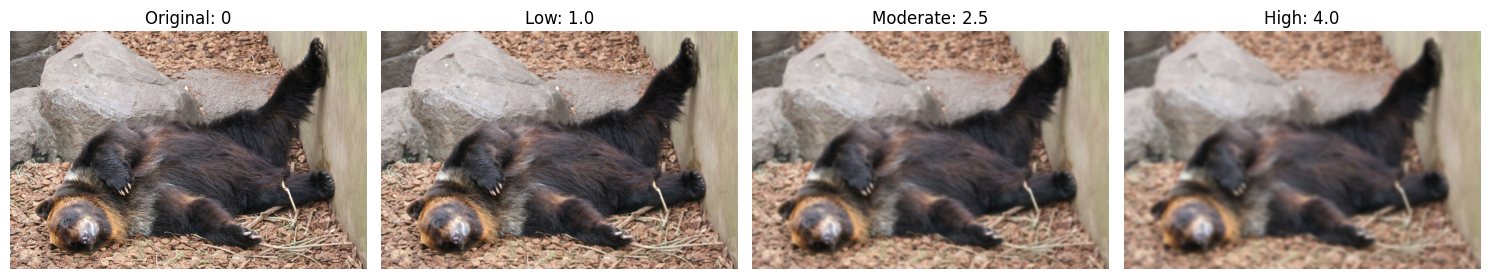

In [ ]:
import matplotlib.pyplot as plt
import os

# Image location
img_name = "14ecdd20a43d33dc.jpg"
img_path = os.path.join(BASE_DIR, "coco", "data", img_name)

# Gaussian blur levels
blur_levels = {
    "Original": 0,
    "Low": 1.0,
    "Moderate": 2.5,
    "High": 4.0
}

# Load original image
img = Image.open(img_path)

# Create blurred versions
blurred_images = [img]
for key, sigma in list(blur_levels.items())[1:]:
    blurred = img.filter(ImageFilter.GaussianBlur(sigma))
    blurred_images.append(blurred)

# Plot all images
fig, axs = plt.subplots(1, len(blur_levels), figsize=(15, 5))
for i, (key, val) in enumerate(blur_levels.items()):
    axs[i].imshow(blurred_images[i])
    axs[i].set_title(f"{key}: {val}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


#Fixed Blur directories
##FOr coco:


In [ ]:
def is_image_file(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # Will throw if not a valid image
        return True
    except Exception:
        return False


def augment_dataset_blur(images_dir, out_dir, aug_val,transform_fn):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for file_name in os.listdir(images_dir):
        src_path = os.path.join(images_dir, file_name)
        if os.path.isdir(src_path) or not is_image_file(src_path):
            continue
        dst_path = os.path.join(out_dir, file_name)
        try:
            transform_fn(src_path, dst_path,aug_val)
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
    print(f"Augmented images saved to: {out_dir}")


In [ ]:
import numpy as np

# Sigma ranges for buckets
low_sigma = 1.2
moderate_sigma = 2.5
high_sigma = 4.0

def apply_gaussian_blur_from_range(img_path, out_path, sigma_range):
    """
    Applies Gaussian blur to an image with a randomly chosen sigma within the specified range.

    Args:
        img_path (str): Path to the input image.
        out_path (str): Path to save the blurred image.
        sigma_range (tuple): A value specifying the value for sigma.
    """
    sigma = sigma_range
    img = Image.open(img_path)
    img_blur = img.filter(ImageFilter.GaussianBlur(sigma))
    img_blur.save(out_path)

In [ ]:
coco_img_dir = os.path.join(BASE_DIR, "coco", "data")
coco_low_dir = os.path.join(BASE_DIR, "coco_blur_low","data")
coco_med_dir = os.path.join(BASE_DIR, "coco_blur_med","data")
coco_high_dir = os.path.join(BASE_DIR, "coco_blur_high","data")

augment_dataset_blur(coco_img_dir, coco_low_dir, low_sigma,apply_gaussian_blur_from_range)
augment_dataset_blur(coco_img_dir, coco_med_dir,moderate_sigma, apply_gaussian_blur_from_range)
augment_dataset_blur(coco_img_dir, coco_high_dir,high_sigma, apply_gaussian_blur_from_range)
# if "coco_blur" in fo.list_datasets():
#     fo.delete_dataset("coco_blur")

# When you create new datasets, point FiftyOne to the correct image+annotation locations:
coco_low_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_blur_low"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_blur_low"
)
coco_med_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_blur_med"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_blur_med"
)
coco_high_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_blur_high"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_blur_high"
)


Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_blur_low/data
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_blur_med/data
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_blur_high/data
 100% |███████████████| 1282/1282 [7.4s elapsed, 0s remaining, 149.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [7.4s elapsed, 0s remaining, 149.9 samples/s]      


 100% |███████████████| 1282/1282 [4.3s elapsed, 0s remaining, 260.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [4.3s elapsed, 0s remaining, 260.8 samples/s]      


 100% |███████████████| 1282/1282 [4.7s elapsed, 0s remaining, 255.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [4.7s elapsed, 0s remaining, 255.9 samples/s]      


##For Yolo

In [ ]:
# Source directories
yolo_img_dir = os.path.join(BASE_DIR, "yolo", "images", "val")
yolo_labels_val = os.path.join(BASE_DIR, "yolo", "labels", "val")

# Target (augmented) directories
yolo_blur_low_dir = os.path.join(BASE_DIR, "yolo_blur_low", "images", "val")
yolo_blur_low_labels = os.path.join(BASE_DIR, "yolo_blur_low", "labels", "val")

yolo_blur_med_dir = os.path.join(BASE_DIR, "yolo_blur_med", "images", "val")
yolo_blur_med_labels = os.path.join(BASE_DIR, "yolo_blur_med", "labels", "val")

yolo_blur_high_dir = os.path.join(BASE_DIR, "yolo_blur_high", "images", "val")
yolo_blur_high_labels = os.path.join(BASE_DIR, "yolo_blur_high", "labels", "val")



# Make necessary directories
os.makedirs(yolo_blur_low_dir, exist_ok=True)
os.makedirs(yolo_blur_low_labels, exist_ok=True)
os.makedirs(yolo_blur_med_dir, exist_ok=True)
os.makedirs(yolo_blur_med_labels, exist_ok=True)
os.makedirs(yolo_blur_high_dir, exist_ok=True)
os.makedirs(yolo_blur_high_labels, exist_ok=True)


augment_dataset_blur(yolo_img_dir, yolo_blur_low_dir,low_sigma, apply_gaussian_blur_from_range)
augment_dataset_blur(yolo_img_dir, yolo_blur_med_dir,moderate_sigma, apply_gaussian_blur_from_range)
augment_dataset_blur(yolo_img_dir, yolo_blur_high_dir,high_sigma, apply_gaussian_blur_from_range)

# YOLO annotation copy
def copy_yolo_labels(src_dir, dst_dir):
    import shutil
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for fname in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))


copy_yolo_labels(yolo_labels_val, yolo_blur_low_dir)
copy_yolo_labels(yolo_labels_val, yolo_blur_med_dir)
copy_yolo_labels(yolo_labels_val, yolo_blur_high_dir)

shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_blur_low", "dataset.yaml"))
shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_blur_med", "dataset.yaml"))
shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_blur_high", "dataset.yaml"))
if "yolo_blur_low" in fo.list_datasets():
    fo.delete_dataset("yolo_blur_low")
if "yolo_blur_med" in fo.list_datasets():
    fo.delete_dataset("yolo_blur_med")

if "yolo_blur_high" in fo.list_datasets():
    fo.delete_dataset("yolo_blur_high")

# FiftyOne import
yolo_blur_low = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_blur_low"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_blur_low"
)

yolo_blur_med = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_blur_med"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_blur_med"
)
yolo_blur_high = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_blur_high"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_blur_high"
)




Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_blur_low/images/val
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_blur_med/images/val
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_blur_high/images/val
 100% |███████████████| 1282/1282 [9.6s elapsed, 0s remaining, 139.6 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [9.6s elapsed, 0s remaining, 139.6 samples/s]       


 100% |███████████████| 1282/1282 [10.4s elapsed, 0s remaining, 98.3 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [10.4s elapsed, 0s remaining, 98.3 samples/s]       


 100% |███████████████| 1282/1282 [8.8s elapsed, 0s remaining, 164.1 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [8.8s elapsed, 0s remaining, 164.1 samples/s]       


In [ ]:
import os



# Get lists of file names
filenames1 = set(os.listdir(yolo_labels_val))
filenames2 = set(os.listdir(yolo_blur_low_labels))
filenames3 = set(os.listdir(yolo_blur_med_labels))
filenames4 = set(os.listdir(yolo_blur_high_labels))

if filenames1 == filenames4:
    print("yolo_img_dir and yolo_blur_low_dir have the same file names.")
else:
    print("yolo_img_dir and yolo_blur_low_dir do not have the same file names.")

yolo_img_dir and yolo_blur_low_dir have the same file names.


In [ ]:
    unique_to_dir1 = filenames2.difference(filenames1)
    print(f"Files unique to the first directory: {unique_to_dir1}")

Files unique to the first directory: {'27c72d848f4d8df8.txt', 'b0955a0210313d64.txt', 'cca89fe3da8caa77.txt', '033797e7b2ae595b.txt', '7af5dad145c8bcb3.txt', '03c2bccf97c631aa.txt', 'ec8c754cf8177485.txt', '8865694899bc5737.txt', 'c81ae20b22437a49.txt', '3a98760d7fc5630f.txt', 'c9ef13bce7afa69c.txt', '8261aa336da70cdf.txt', '814912f96ea43a01.txt', '165478b07691ee17.txt', '053ab9bcb0f05d96.txt', '290ca9a215571ac2.txt', '7268e678c9efab8b.txt', '8a2088dad15de99f.txt', 'a391997e83ef4bb3.txt', '4f00dd75d2a2131c.txt', '3afdc663f87fcd35.txt', 'fb304b83051aa0f5.txt', 'f7aed869109e2288.txt', '4e2fb16ded97de34.txt', 'd88b5485a9c1a3e1.txt', '19f1845c407ce846.txt', '59a6d78cf351dcdc.txt', '94c7ec3aee8f750a.txt', 'c232ae91a5cffe3c.txt', '0329708e66a64efb.txt', 'bba8394389191d0d.txt', '0d01927ad866d3e3.txt', '7077e8b795c9d9b5.txt', 'ad1f6c8a44466cc6.txt', '028f8db193a85ecf.txt', 'c91d59eadd9264bd.txt', 'f469dfc18ac7517c.txt', '6cd3fc517d3fbc88.txt', '4dbaff43bc6fe55e.txt', '905cb6df9ac5bf41.txt', '5

In [ ]:
!mv /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_jpeg_high/images/val/*.txt "/content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_jpeg_high/labels/val/"

# Separating JPEG directories too
##for coco

In [ ]:
low_comp = 90
med_comp = 70
high_comp = 50
def fixed_jpeg_compression(img_path, out_path, quality):
    img = Image.open(img_path)
    img.save(out_path, "JPEG", quality=quality)

In [ ]:
coco_img_dir = os.path.join(BASE_DIR, "coco", "data")
coco_jpeg_low_dir = os.path.join(BASE_DIR, "coco_jpeg_low","data")
coco_jpeg_med_dir = os.path.join(BASE_DIR, "coco_jpeg_med","data")
coco_jpeg_high_dir = os.path.join(BASE_DIR, "coco_jpeg_high","data")

augment_dataset_blur(coco_img_dir, coco_jpeg_low_dir, low_comp, fixed_jpeg_compression)
augment_dataset_blur(coco_img_dir, coco_jpeg_med_dir, med_comp, fixed_jpeg_compression)
augment_dataset_blur(coco_img_dir, coco_jpeg_high_dir, high_comp, fixed_jpeg_compression)
if "coco_blur" in fo.list_datasets():
    fo.delete_dataset("coco_blur")

coco_jpeg_low_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_jpeg_low"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_jpeg_low"
)

coco_jpeg_med_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_jpeg_med"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_jpeg_med"
)

coco_jpeg_high_dataset = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "coco_jpeg_high"),
    labels_path=os.path.join(BASE_DIR, "coco", "labels.json"),
    dataset_type=fo.types.COCODetectionDataset,
    name="coco_jpeg_high"
)


Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_jpeg_low/data
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_jpeg_med/data
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_jpeg_high/data
 100% |███████████████| 1282/1282 [5.2s elapsed, 0s remaining, 249.3 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [5.2s elapsed, 0s remaining, 249.3 samples/s]       


 100% |███████████████| 1282/1282 [5.2s elapsed, 0s remaining, 256.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [5.2s elapsed, 0s remaining, 256.1 samples/s]      


 100% |███████████████| 1282/1282 [6.8s elapsed, 0s remaining, 159.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [6.8s elapsed, 0s remaining, 159.1 samples/s]      


##for yolo

In [ ]:
# Source directories
yolo_img_dir = os.path.join(BASE_DIR, "yolo", "images", "val")
yolo_labels_val = os.path.join(BASE_DIR, "yolo", "labels", "val")

# Target (augmented) directories
yolo_jpeg_low_dir = os.path.join(BASE_DIR, "yolo_jpeg_low", "images", "val")
yolo_jpeg_low_labels = os.path.join(BASE_DIR, "yolo_jpeg_low", "labels", "val")

yolo_jpeg_med_dir = os.path.join(BASE_DIR, "yolo_jpeg_med", "images", "val")
yolo_jpeg_med_labels = os.path.join(BASE_DIR, "yolo_jpeg_med", "labels", "val")

yolo_jpeg_high_dir = os.path.join(BASE_DIR, "yolo_jpeg_high", "images", "val")
yolo_jpeg_high_labels = os.path.join(BASE_DIR, "yolo_jpeg_high", "labels", "val")



# Make necessary directories
os.makedirs(yolo_jpeg_low_dir, exist_ok=True)
os.makedirs(yolo_jpeg_low_labels, exist_ok=True)
os.makedirs(yolo_jpeg_med_dir, exist_ok=True)
os.makedirs(yolo_jpeg_med_labels, exist_ok=True)
os.makedirs(yolo_jpeg_high_dir, exist_ok=True)
os.makedirs(yolo_jpeg_high_labels, exist_ok=True)


augment_dataset_blur(yolo_img_dir, yolo_jpeg_low_dir,low_comp, fixed_jpeg_compression)
augment_dataset_blur(yolo_img_dir, yolo_jpeg_med_dir,med_comp, fixed_jpeg_compression)
augment_dataset_blur(yolo_img_dir, yolo_jpeg_high_dir,high_comp, fixed_jpeg_compression)

# YOLO annotation copy
def copy_yolo_labels(src_dir, dst_dir):
    import shutil
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for fname in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))


copy_yolo_labels(yolo_labels_val, yolo_jpeg_low_dir)
copy_yolo_labels(yolo_labels_val, yolo_jpeg_med_dir)
copy_yolo_labels(yolo_labels_val, yolo_jpeg_high_dir)

shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_jpeg_low", "dataset.yaml"))
shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_jpeg_med", "dataset.yaml"))
shutil.copy(os.path.join(BASE_DIR, "yolo", "dataset.yaml"), os.path.join(BASE_DIR, "yolo_jpeg_high", "dataset.yaml"))


# FiftyOne import
yolo_jpeg_low = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_jpeg_low"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_jpeg_low"
)

yolo_jpeg_med = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_jpeg_med"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_jpeg_med"
)
yolo_jpeg_high = fo.Dataset.from_dir(
    dataset_dir=os.path.join(BASE_DIR, "yolo_jpeg_high"),
    dataset_type=fo.types.YOLOv5Dataset,
    name="yolo_jpeg_high"
)


Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_jpeg_low/images/val
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_jpeg_med/images/val
Augmented images saved to: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/yolo_jpeg_high/images/val
 100% |███████████████| 1282/1282 [10.3s elapsed, 0s remaining, 131.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [10.3s elapsed, 0s remaining, 131.1 samples/s]      


 100% |███████████████| 1282/1282 [10.5s elapsed, 0s remaining, 143.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [10.5s elapsed, 0s remaining, 143.6 samples/s]      


 100% |███████████████| 1282/1282 [10.2s elapsed, 0s remaining, 106.2 samples/s]     


INFO:eta.core.utils: 100% |███████████████| 1282/1282 [10.2s elapsed, 0s remaining, 106.2 samples/s]     


In [ ]:
low_comp = 90
med_comp = 70
high_comp = 50
def fixed_jpeg_compression(img_path, out_path, quality):
    img = Image.open(img_path)
    img.save(out_path, "JPEG", quality=quality)

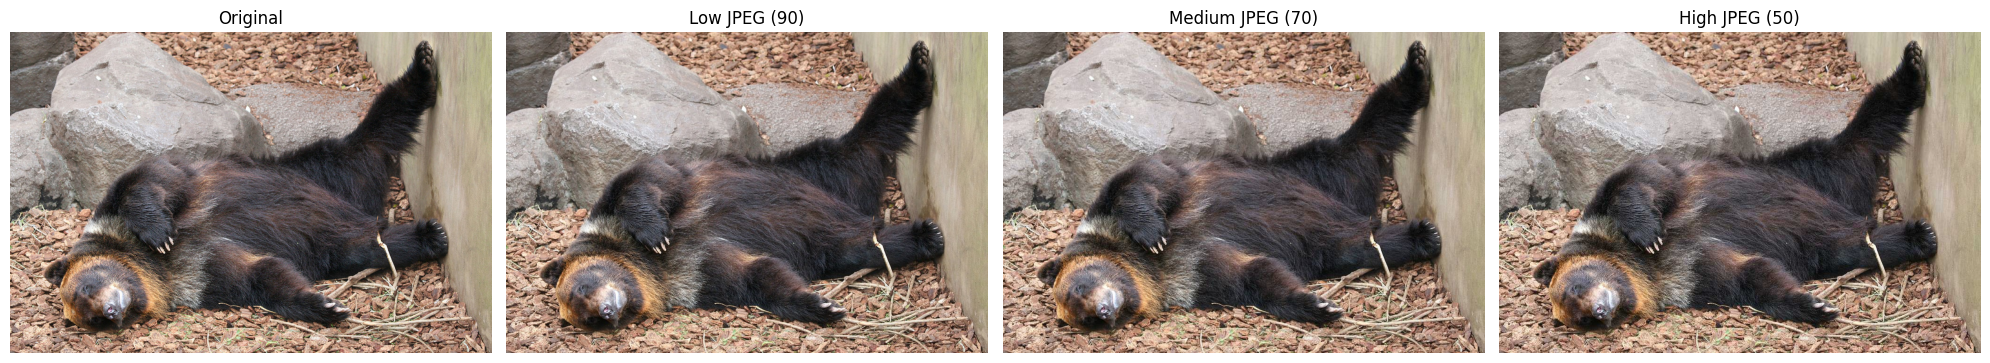

In [ ]:
import matplotlib.pyplot as plt

# Create a list of images and their titles
images_to_plot = {
    "Original": original_img,
    f"Low JPEG ({low_comp})": low_compressed_img,
    f"Medium JPEG ({med_comp})": med_compressed_img,
    f"High JPEG ({high_comp})": high_compressed_img
}

# Plot all images
fig, axs = plt.subplots(1, len(images_to_plot), figsize=(20, 5))
for i, (title, img) in enumerate(images_to_plot.items()):
    axs[i].imshow(img)
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

#Plotting Jpeg compression

In [ ]:
img_name = "14ecdd20a43d33dc.jpg"

# Original image path
original_img_path = os.path.join(BASE_DIR, "coco", "data", img_name)
print(f"Original image path: {original_img_path}")

# Low JPEG compressed image path
low_compressed_img_path = os.path.join(BASE_DIR, "coco_jpeg_low", "data", img_name)
print(f"Low JPEG compressed image path: {low_compressed_img_path}")

# Medium JPEG compressed image path
med_compressed_img_path = os.path.join(BASE_DIR, "coco_jpeg_med", "data", img_name)
print(f"Medium JPEG compressed image path: {med_compressed_img_path}")

# High JPEG compressed image path
high_compressed_img_path = os.path.join(BASE_DIR, "coco_jpeg_high", "data", img_name)
print(f"High JPEG compressed image path: {high_compressed_img_path}")

Original image path: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco/data/14ecdd20a43d33dc.jpg
Low JPEG compressed image path: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_jpeg_low/data/14ecdd20a43d33dc.jpg
Medium JPEG compressed image path: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_jpeg_med/data/14ecdd20a43d33dc.jpg
High JPEG compressed image path: /content/drive/MyDrive/my_fiftyone_datasets/open-images-animals/coco_jpeg_high/data/14ecdd20a43d33dc.jpg


In [ ]:
import os

# Load original image and get its size
original_img = Image.open(original_img_path)
original_img_size_bytes = os.path.getsize(original_img_path)
print(f"Original image size: {original_img_size_bytes} bytes")

# Load low compressed image and get its size
low_compressed_img = Image.open(low_compressed_img_path)
low_compressed_img_size_bytes = os.path.getsize(low_compressed_img_path)
print(f"Low JPEG compressed image size: {low_compressed_img_size_bytes} bytes")

# Load medium compressed image and get its size
med_compressed_img = Image.open(med_compressed_img_path)
med_compressed_img_size_bytes = os.path.getsize(med_compressed_img_path)
print(f"Medium JPEG compressed image size: {med_compressed_img_size_bytes} bytes")

# Load high compressed image and get its size
high_compressed_img = Image.open(high_compressed_img_path)
high_compressed_img_size_bytes = os.path.getsize(high_compressed_img_path)
print(f"High JPEG compressed image size: {high_compressed_img_size_bytes} bytes")

Original image size: 287610 bytes
Low JPEG compressed image size: 269917 bytes
Medium JPEG compressed image size: 145472 bytes
High JPEG compressed image size: 120225 bytes


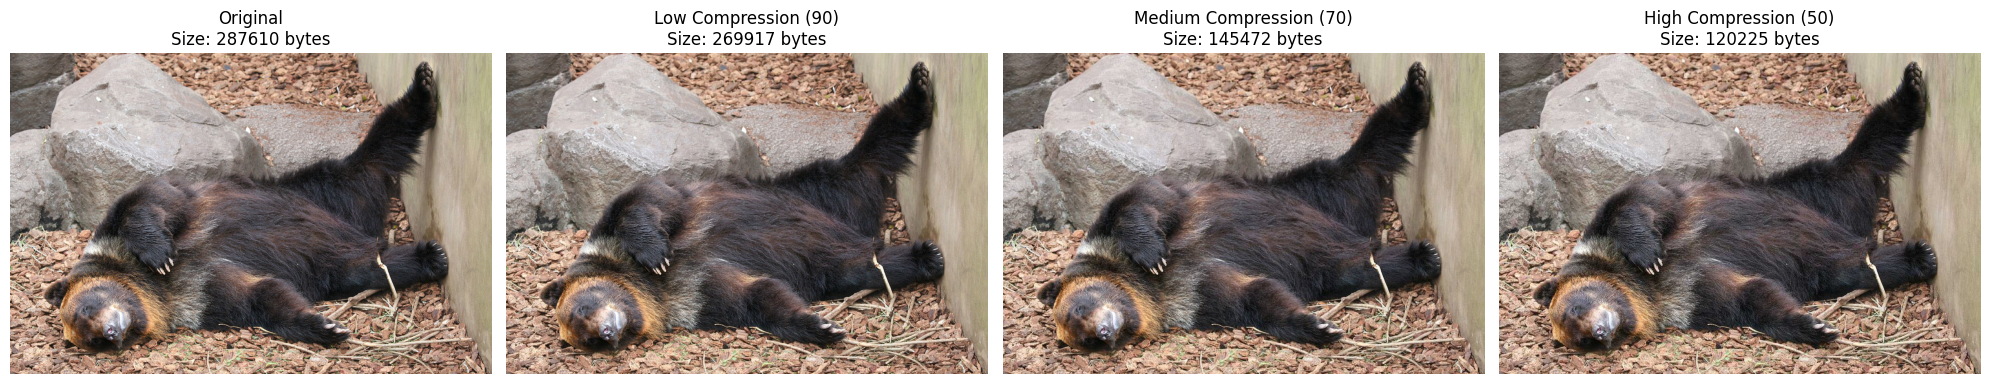

In [ ]:
import matplotlib.pyplot as plt

# Create a list of images and their details for plotting
images_data = [
    {"title": "Original", "image": original_img, "size": original_img_size_bytes},
    {"title": f"Low Compression ({low_comp})", "image": low_compressed_img, "size": low_compressed_img_size_bytes},
    {"title": f"Medium Compression ({med_comp})", "image": med_compressed_img, "size": med_compressed_img_size_bytes},
    {"title": f"High Compression ({high_comp})", "image": high_compressed_img, "size": high_compressed_img_size_bytes}
]

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, len(images_data), figsize=(20, 5))

# Iterate through the images and plot them
for i, data in enumerate(images_data):
    axs[i].imshow(data["image"])
    axs[i].set_title(f"{data['title']}\nSize: {data['size']} bytes")
    axs[i].axis('off') # Turn off the axis

# Adjust subplot parameters for a tight layout
plt.tight_layout()

# Display the plot
plt.show()